In [1]:
import polars as pl
import polars.selectors as cs
import seaborn as sbn
import matplotlib.pyplot as plt

# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)
print(pl.__version__)

1.6.0


We're going to use a new dataset here, to demonstrate how to deal with larger datasets. This is a subset of the of 311 service requests from [NYC Open Data](https://nycopendata.socrata.com/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9). 

In [2]:
# because of mixed types we specify dtype to prevent any errors
complaints = pl.read_csv('../data/311-service-requests.csv', schema_overrides={'Incident Zip':pl.String})

Notice that we had to explicitly specify the dtype of the 'Incident Zip' column as a string type. This means that it's encountered a problem reading in our data. In this case it almost certainly means that it has columns where some of the entries are strings and some are integers.

For now we're going to ignore it and hope we don't run into a problem, but in the long run we'd need to investigate this warning.

# 2.1 What's even in it? (the summary)

Use the head function to get the top rows of a dataframe This is a great way to get a sense for what kind of information is in the dataframe -- take a minute to look at the contents and get a feel for this dataset.

In [3]:
complaints.head()

Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str
26589651,"""10/31/2013 02:08:41 AM""",null,"""NYPD""","""New York City Police Departmen…","""Noise - Street/Sidewalk""","""Loud Talking""","""Street/Sidewalk""","""11432""","""90-03 169 STREET""","""169 STREET""","""90 AVENUE""","""91 AVENUE""",null,null,"""ADDRESS""","""JAMAICA""",null,"""Precinct""","""Assigned""","""10/31/2013 10:08:41 AM""","""10/31/2013 02:35:17 AM""","""12 QUEENS""","""QUEENS""",1042027,197389,"""Unspecified""","""QUEENS""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""N""",null,null,null,null,null,null,null,null,null,null,null,40.708275,-73.791604,"""(40.70827532593202, -73.791603…"
26593698,"""10/31/2013 02:01:04 AM""",null,"""NYPD""","""New York City Police Departmen…","""Illegal Parking""","""Commercial Overnight Parking""","""Street/Sidewalk""","""11378""","""58 AVENUE""","""58 AVENUE""","""58 PLACE""","""59 STREET""",null,null,"""BLOCKFACE""","""MASPETH""",null,"""Precinct""","""Open""","""10/31/2013 10:01:04 AM""",null,"""05 QUEENS""","""QUEENS""",1009349,201984,"""Unspecified""","""QUEENS""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""N""",null,null,null,null,null,null,null,null,null,null,null,40.721041,-73.909453,"""(40.721040535628305, -73.90945…"
26594139,"""10/31/2013 02:00:24 AM""","""10/31/2013 02:40:32 AM""","""NYPD""","""New York City Police Departmen…","""Noise - Commercial""","""Loud Music/Party""","""Club/Bar/Restaurant""","""10032""","""4060 BROADWAY""","""BROADWAY""","""WEST 171 STREET""","""WEST 172 STREET""",null,null,"""ADDRESS""","""NEW YORK""",null,"""Precinct""","""Closed""","""10/31/2013 10:00:24 AM""","""10/31/2013 02:39:42 AM""","""12 MANHATTAN""","""MANHATTAN""",1001088,246531,"""Unspecified""","""MANHATTAN""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""N""",null,null,null,null,null,null,null,null,null,null,null,40.84333,-73.939144,"""(40.84332975466513, -73.939143…"
26595721,"""10/31/2013 01:56:23 AM""","""10/31/2013 02:21:48 AM""","""NYPD""","""New York City Police Departmen…","""Noise - Vehicle""","""Car/Truck Horn""","""Street/Sidewalk""","""10023""","""WEST 72 STREET""","""WEST 72 STREET""","""COLUMBUS AVENUE""","""AMSTERDAM AVENUE""",null,null,"""BLOCKFACE""","""NEW YORK""",null,"""Precinct""","""Closed""","""10/31/2013 09:56:23 AM""","""10/31/2013 02:21:10 AM""","""07 MANHATTAN""","""MANHATTAN""",989730,222727,"""Unspecified""","""MANHATTAN""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""N""",null,null,null,null,null,null,null,null,null,null,null,40.778009,-73.980213,"""(40.7780087446372, -73.9802134…"
26590930,"""

# 2.2 Selecting a single column (a Series)

Polars offers two methods to get a single column (ie, a pl.Series object). The robust and functional way is to use the `df.get_column` function, but you can also use the [] syntax to save a few keystrokes. The reason why `df.get_column` is more robust is that `df.get_column` will always return a `Series` whereas indexing with [] may return a `Series` or `DataFrame` depending on the input.

In [4]:
single_column = complaints.get_column('Complaint Type') # can also use complaints['Complaint Type']
display(type(single_column))
display(single_column)

polars.series.series.Series

Complaint Type
str
"""Noise - Street/Sidewalk"""
"""Illegal Parking"""
"""Noise - Commercial"""
"""Noise - Vehicle"""
"""Rodent"""
…
"""Maintenance or Facility"""
"""Illegal Parking"""
"""Noise - Street/Sidewalk"""


`Series` objects also have a `head` function:

In [5]:
complaints['Complaint Type'].head()

Complaint Type
str
"""Noise - Street/Sidewalk"""
"""Illegal Parking"""
"""Noise - Commercial"""
"""Noise - Vehicle"""
"""Rodent"""
"""Noise - Commercial"""
"""Blocked Driveway"""
"""Noise - Commercial"""
"""Noise - Commercial"""


# 2.3 Selecting multiple columns (a DataFrame)

What if we just want to know the complaint type and the borough, but not the rest of the information? Polars provides the `df.select` method to select multiple columns. This method always returns a DataFrame.

In [6]:
complaints.select('Complaint Type', 'Borough').head()

Complaint Type,Borough
str,str
"""Noise - Street/Sidewalk""","""QUEENS"""
"""Illegal Parking""","""QUEENS"""
"""Noise - Commercial""","""MANHATTAN"""
"""Noise - Vehicle""","""MANHATTAN"""
"""Rodent""","""MANHATTAN"""


The `polars.selectors` module (imported as `cs`) offers a powerful syntax for fine-tuned column selection. Here, we select the `Created Date` column along with all columns with "School" in their name.

In [7]:
complaints.select('Created Date', cs.contains('School')).head()

Created Date,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint
str,str,str,str,str,str,str,str,str,str,str,str
"""10/31/2013 02:08:41 AM""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""N""",null
"""10/31/2013 02:01:04 AM""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""N""",null
"""10/31/2013 02:00:24 AM""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""N""",null
"""10/31/2013 01:56:23 AM""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""N""",null
"""10/31/2013 01:53:44 AM""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""Unspecified""","""N""",null


# 2.4 What's the most common complaint type?

This is a really easy question to answer! There's a `value_counts()` method that we can use:

In [8]:
complaints['Complaint Type'].value_counts(sort=True)

Complaint Type,count
str,u32
"""HEATING""",14200
"""GENERAL CONSTRUCTION""",7471
"""Street Light Condition""",7117
"""DOF Literature Request""",5797
"""PLUMBING""",5373
…,…
"""Open Flame Permit""",1
"""DWD""",1
"""Highway Sign - Damaged""",1


If we just wanted the top 10 most common complaints, we can use the `top_k` function like so:

In [9]:
complaint_counts = complaints['Complaint Type'].value_counts().top_k(10, by='count')
complaint_counts

Complaint Type,count
str,u32
"""HEATING""",14200
"""GENERAL CONSTRUCTION""",7471
"""Street Light Condition""",7117
"""DOF Literature Request""",5797
"""PLUMBING""",5373
"""PAINT - PLASTER""",5149
"""Blocked Driveway""",4590
"""NONCONST""",3998
"""Street Condition""",3473


But it gets better! We can plot them!

<Axes: xlabel='Complaint Type', ylabel='count'>

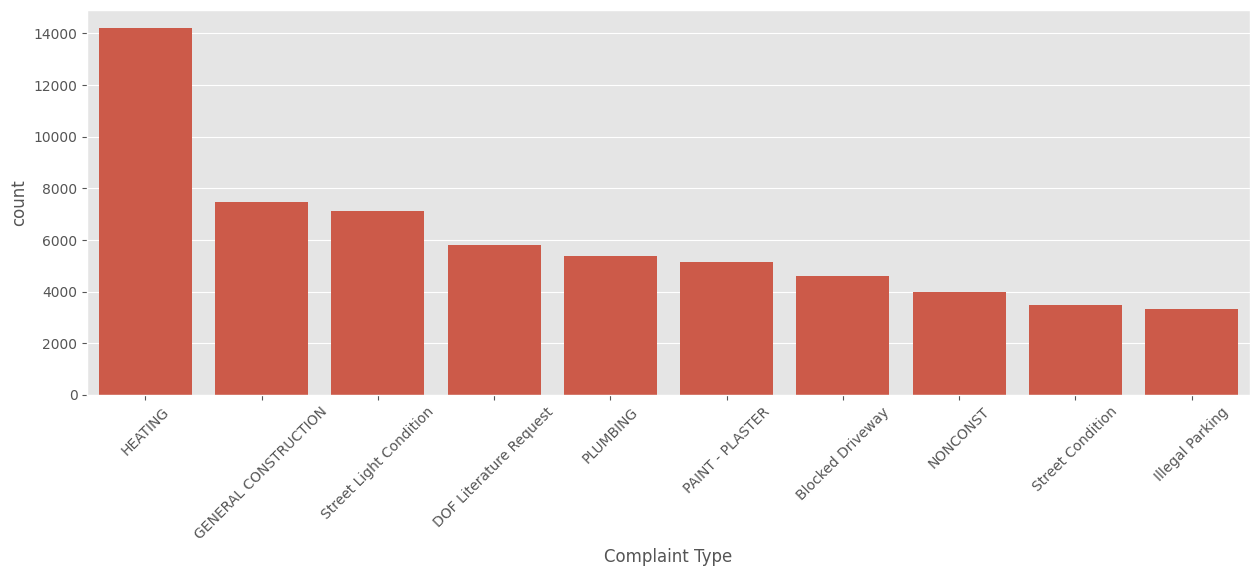

In [10]:
plt.xticks(rotation=45)
sbn.barplot(complaint_counts, x='Complaint Type', y='count')

<style>
    @font-face {
        font-family: "Computer Modern";
        src: url('http://mirrors.ctan.org/fonts/cm-unicode/fonts/otf/cmunss.otf');
    }
    div.cell{
        width:800px;
        margin-left:16% !important;
        margin-right:auto;
    }
    h1 {
        font-family: Helvetica, serif;
    }
    h4{
        margin-top:12px;
        margin-bottom: 3px;
       }
    div.text_cell_render{
        font-family: Computer Modern, "Helvetica Neue", Arial, Helvetica, Geneva, sans-serif;
        line-height: 145%;
        font-size: 130%;
        width:800px;
        margin-left:auto;
        margin-right:auto;
    }
    .CodeMirror{
            font-family: "Source Code Pro", source-code-pro,Consolas, monospace;
    }
    .text_cell_render h5 {
        font-weight: 300;
        font-size: 22pt;
        color: #4057A1;
        font-style: italic;
        margin-bottom: .5em;
        margin-top: 0.5em;
        display: block;
    }
    
    .warning{
        color: rgb( 240, 20, 20 )
        }  